In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import reshape, nest, config
from tensorflow.keras.datasets import mnist
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
from sklearn import preprocessing
from uuid import uuid4
import pickle
np.random.seed(0)

# Set up data

In [3]:
datapath = '/ssd003/projects/pets/application_train.csv'
raw_train = pd.read_csv(datapath)
raw_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing Function

In [4]:
def data_preprocessing(df):
    target = 'TARGET'
    id_col = 'SK_ID_CURR'

    #Delete target column as it is not useful for prediction
    del df[id_col]

    #Distribution of target variable
    df[target].value_counts()

    #Store target variable to be used later
    target_val = df[target]

    #Delete target column from features
    target_col = df.pop(target)

    # Write UID
    uid_col = pd.Series([uuid4() for _ in range(len(df))])

    # Get all continuous variabels 
    cont_vars = []
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            cont_vars.append(col)

    #Store number of continous variable. This will be equivalent to number of neurons in input layer
    cont_train = df.loc[:, cont_vars]
    curr_dim = cont_train.shape[1]
    
    #Fill NAs with mean value of column. Lot of scope of improvement here :)
    cont_train = cont_train.fillna(cont_train.mean())

    #Normalize features using standard scaler. We will use same standard scaler object to normalize test data
    std_scale = preprocessing.StandardScaler().fit(cont_train[cont_vars])
    cont_train[cont_vars] = std_scale.transform(cont_train[cont_vars])
    
    # Extract home credit subdataset
    home_credit_cols = [col for col in cont_train.columns if "credit_bureau" not in str.lower(col)]
    home_credit_df = cont_train[home_credit_cols].copy()
    home_credit_df["target"] = target_col
    return home_credit_df

# Set up partitions

In [5]:
positive_class = raw_train[raw_train.TARGET == 1]
negative_class = raw_train[raw_train.TARGET == 0]
(len(positive_class), len(negative_class))

(24825, 282686)

In [6]:
len(positive_class) / 4

6206.25

In [7]:
n_positive = 6000
n_negative = 14000
(n_positive, n_negative, n_positive + n_negative, n_positive/(n_positive + n_negative))

(6000, 14000, 20000, 0.3)

In [8]:
pos_sizes = np.cumsum([n_positive, n_positive, n_positive, n_positive])
pos_dfs = np.array_split(positive_class.sample(frac=1), pos_sizes)
print([len(d) for d in pos_dfs])

[6000, 6000, 6000, 6000, 825]


In [9]:
neg_sizes = np.cumsum([n_negative, n_negative, n_negative, n_negative])
neg_dfs = np.array_split(negative_class.sample(frac=1), neg_sizes)
print([len(d) for d in neg_dfs])

[14000, 14000, 14000, 14000, 226686]


In [10]:
#sizes = np.cumsum([10000, 10000, 10000, 10000])
#dfs = np.array_split(raw_train.sample(frac=1), sizes)
#print([len(d) for d in dfs])

In [11]:
data1 = data_preprocessing(pd.concat([pos_dfs[0], neg_dfs[0]]).sample(frac=1))
data1['hospital_id'] = 1

data2 = data_preprocessing(pd.concat([pos_dfs[1], neg_dfs[1]]).sample(frac=1))
data2['hospital_id'] = 2

data3 = data_preprocessing(pd.concat([pos_dfs[2], neg_dfs[2]]).sample(frac=1))
data3['hospital_id'] = 3

data4 = data_preprocessing(pd.concat([pos_dfs[3], neg_dfs[3]]).sample(frac=1))
data4['hospital_id'] = 4

In [12]:
print(len(data1)) 
print(data1.target.value_counts(normalize=True))
print(len(data2)) 
print(data2.target.value_counts(normalize=True))
print(len(data3)) 
print(data3.target.value_counts(normalize=True))
print(len(data4)) 
print(data4.target.value_counts(normalize=True))

20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64
20000
0    0.7
1    0.3
Name: target, dtype: float64


In [34]:
pickle.dump(data, open("data.pkl.gz",'wb'))

# Combine and format DataFrame

In [13]:
data = pd.concat([data1, data2, data3, data4])

In [14]:
df = data
new = df.copy()
del new['target']
data['features']= new.values.tolist()

#data['hospital_id'] = np.random.randint(1,5, size=len(data))
data = data[['target', 'hospital_id', 'features']]
data.index = range(len(data))

In [15]:
data.head()

,target,hospital_id,features
0,0,1,"[-0.5839614690282836, 0.5990085327679894, -0.2..."
1,0,1,"[-0.5839614690282836, 0.8281093138655685, -0.8..."
2,0,1,"[2.1640925028695217, -0.7755961538174854, -0.4..."
3,1,1,"[0.790065516920619, 1.0572100949631478, 0.0289..."
4,1,1,"[-0.5839614690282836, -0.088293810524748, 1.73..."


In [16]:
data.shape

(80000, 3)

In [17]:
data.hospital_id.value_counts()

4    20000
3    20000
2    20000
1    20000
Name: hospital_id, dtype: int64

# Number of features

In [18]:
n_features = len(data['features'][0])
n_features

99

# Set up the sets of ids

In [19]:
client_id_colname = 'hospital_id' #column that represents client ID 
number_of_training_clients = 3

# split client_id into train and test clients
#client_ids = data[client_id_colname].unique()
#train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
#test_client_ids = [x for x in client_ids if x not in train_client_ids]

train_client_ids = [1,2,3]
test_client_ids = [4]

# Create some TF datasets

In [20]:
SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 10

def create_tf_dataset_for_client_fn(client_id):
    client_data = data[data[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [21]:
if tff.__version__ < "0.19.0":

    train_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=train_client_ids,   
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=test_client_ids,
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
else:
    train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=train_client_ids, 
        serializable_dataset_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=test_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn)

# Batch preprocessing function

In [22]:
NUM_EPOCHS = 10
BATCH_SIZE = 5000
PREFETCH_BUFFER = 2500
def preprocess(dataset):
    def batch_format_fn(element):    
        return collections.OrderedDict(x=tf.reshape(element['features'], [-1,n_features]),
                                       y=tf.reshape(element['target'], [-1,1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [23]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[2]
    )
print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

<RepeatDataset element_spec={'target': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'hospital_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'features': TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)}>
{'target': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, 'hospital_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'features': <tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[ 7.70581126e-01,  1.09867775e+00,  2.24713349e+00,
         2.52058029e+00,  2.30920148e+00, -9.74063635e-01,
         1.04579306e+00, -4.29864854e-01,  3.68262261e-01,
        -4.79886770e-01,  1.10729980e+00,  0.00000000e+00,
         4.44850206e-01, -5.15113831e-01,  4.53234054e-02,
        -6.11172676e-01, -2.46313512e-01,  9.02019024e-01,
        -1.41184255e-01, -1.06836975e-01,  6.03839278e-01,
        -1.24236092e-01, -2.32776970e-01, -2.09253103e-01,
        -3.10727119e-01, -5.79813659e-01, -4.92880136e-01,
         0

In [24]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[ 0.7705811 ,  0.09444522, -1.0509986 , ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [-0.5953342 , -0.00597803,  0.36628214, ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [ 0.7705811 , -0.07292686,  0.21691088, ..., -0.02121798,
                      -0.02345853,  3.        ],
                     ...,
                     [ 0.7705811 ,  1.0986778 , -0.54125285, ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [ 2.1364965 , -0.40767103, -0.705205  , ..., -0.02121798,
                      -0.02345853,  3.        ],
                     [-0.5953342 , -0.40767103,  1.3695558 , ..., -0.02121798,
                      -0.02345853,  3.        ]], dtype=float32)),
             ('y',
              array([[1],
                     [0],
                     [0],
                     ...,
                     [0],
                    

In [25]:
sample_batch['x'].shape

(5000, 99)

# Federated data preprocessing

In [26]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Client datasets

In [27]:
%%time
#train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
federated_train_data = make_federated_data(train_data, train_data.client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 3
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>
CPU times: user 16.2 s, sys: 253 ms, total: 16.4 s
Wall time: 16.4 s


# Keras model

In [28]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(n_features,)), # n_features
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

In [29]:
import tensorflow_addons as tfa

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])

/ssd003/projects/aieng/public/pets_unified/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.8.0-dev20211102). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


# TensorFlow Federated simulation process

In [30]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1)) 

# Training Loop

In [32]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_test_data = make_federated_data(test_data, test_client_ids)

In [33]:
def training_loop(federated_train_data, federated_test_data, iterative_process, NUM_ROUNDS):
    
    list_metrics = []
    list_val_metrics = []

    state = iterative_process.initialize()

    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        val_metrics = evaluation(state.model, federated_test_data)

        list_metrics.append(metrics)
        list_val_metrics.append(val_metrics)
        
        print()
        print(pd.concat([
            pd.DataFrame([list_val_metrics[i]['eval'] for i in range(len(list_val_metrics))]),
            pd.DataFrame([list_metrics[i]['train'] for i in range(len(list_metrics))]),
        ], axis=1))

    return {
        'state':state,
        'training':list_metrics,
        'eval':list_val_metrics,
    }

### Three clients

In [35]:
%%time
results = []

for i in range(10):
    print()
    print(i)
    
    train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
            client_ids=[1,2,3], 
            serializable_dataset_fn=create_tf_dataset_for_client_fn)

    federated_train_data = make_federated_data(train_data, [1,2,3])

    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))

    result = training_loop(federated_train_data, federated_test_data, iterative_process, 20)
    results.append(result)


0
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`



   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0            0.553   0.312977    0.41  0.515066  0.738455         0.724548   

   Precision    Recall       AUC      loss  
0   0.605488  0.234838  0.714903  0.548837  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.5530   0.312977  0.4100  0.515066  0.738455         0.724548   
1           0.6244   0.356981  0.3145  0.571337  0.700691         0.726944   

   Precision    Recall       AUC      loss  
0   0.605488  0.234838  0.714903  0.548837  
1   0.611134  0.246943  0.719993  0.545609  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5530   0.312977  0.410000  0.515066  0.738455         0.724548   
1           0.6244   0.356981  0.314500  0.571337  0.700691         0.726944   
2           0.6605   0.399797  0.262667  0.613945  0.669277         0.728727   

   Precision    Recall       AUC      loss  
0   0.605488  


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.55300   0.312977  0.410000  0.515066  0.738455         0.724548   
1           0.62440   0.356981  0.314500  0.571337  0.700691         0.726944   
2           0.66050   0.399797  0.262667  0.613945  0.669277         0.728727   
3           0.68000   0.437500  0.233333  0.643536  0.643219         0.730122   
4           0.69175   0.469989  0.215333  0.664311  0.621715         0.731267   
5           0.69840   0.493443  0.200667  0.678986  0.604092         0.732201   
6           0.70265   0.511899  0.190000  0.689941  0.589806         0.732948   
7           0.70715   0.534827  0.183000  0.698211  0.578364         0.733607   
8           0.70970   0.549949  0.178000  0.704689  0.569338         0.734141   
9           0.71215   0.565997  0.173667  0.709732  0.562336         0.734577   
10          0.71485   0.584231  0.171667  0.713866  0.556995         0.734944   
11          0.71660   0.598


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.55300   0.312977  0.410000  0.515066  0.738455         0.724548   
1           0.62440   0.356981  0.314500  0.571337  0.700691         0.726944   
2           0.66050   0.399797  0.262667  0.613945  0.669277         0.728727   
3           0.68000   0.437500  0.233333  0.643536  0.643219         0.730122   
4           0.69175   0.469989  0.215333  0.664311  0.621715         0.731267   
5           0.69840   0.493443  0.200667  0.678986  0.604092         0.732201   
6           0.70265   0.511899  0.190000  0.689941  0.589806         0.732948   
7           0.70715   0.534827  0.183000  0.698211  0.578364         0.733607   
8           0.70970   0.549949  0.178000  0.704689  0.569338         0.734141   
9           0.71215   0.565997  0.173667  0.709732  0.562336         0.734577   
10          0.71485   0.584231  0.171667  0.713866  0.556995         0.734944   
11          0.71660   0.598


   binary_accuracy  Precision    Recall       AUC     loss  binary_accuracy  \
0           0.5708   0.345418  0.481167  0.563677  0.70085         0.726888   

   Precision    Recall       AUC      loss  
0   0.608486  0.251352  0.718741  0.546301  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5708   0.345418  0.481167  0.563677  0.700850         0.726888   
1           0.6305   0.387395  0.398500  0.607763  0.667014         0.728903   

   Precision    Recall       AUC      loss  
0   0.608486  0.251352  0.718741  0.546301  
1   0.613524  0.260337  0.722921  0.543588  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5708   0.345418  0.481167  0.563677  0.700850         0.726888   
1           0.6305   0.387395  0.398500  0.607763  0.667014         0.728903   
2           0.6662   0.428662  0.338500  0.641590  0.639406         0.730580   

   Precision    Recall       AUC      loss  
0   0.


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57080   0.345418  0.481167  0.563677  0.700850         0.726888   
1           0.63050   0.387395  0.398500  0.607763  0.667014         0.728903   
2           0.66620   0.428662  0.338500  0.641590  0.639406         0.730580   
3           0.68885   0.470354  0.294833  0.666511  0.617001         0.731894   
4           0.70265   0.508373  0.268167  0.684422  0.598921         0.732906   
5           0.71065   0.538545  0.248000  0.697333  0.584467         0.733744   
6           0.71560   0.561807  0.236333  0.706680  0.573061         0.734415   
7           0.71715   0.573134  0.224000  0.713477  0.564166         0.734936   
8           0.71875   0.584194  0.216833  0.718261  0.557360         0.735402   
9           0.71975   0.593029  0.209833  0.721998  0.552256         0.735798   
10          0.72185   0.606533  0.207333  0.724916  0.548544         0.736140   
11          0.72315   0.616


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57080   0.345418  0.481167  0.563677  0.700850         0.726888   
1           0.63050   0.387395  0.398500  0.607763  0.667014         0.728903   
2           0.66620   0.428662  0.338500  0.641590  0.639406         0.730580   
3           0.68885   0.470354  0.294833  0.666511  0.617001         0.731894   
4           0.70265   0.508373  0.268167  0.684422  0.598921         0.732906   
5           0.71065   0.538545  0.248000  0.697333  0.584467         0.733744   
6           0.71560   0.561807  0.236333  0.706680  0.573061         0.734415   
7           0.71715   0.573134  0.224000  0.713477  0.564166         0.734936   
8           0.71875   0.584194  0.216833  0.718261  0.557360         0.735402   
9           0.71975   0.593029  0.209833  0.721998  0.552256         0.735798   
10          0.72185   0.606533  0.207333  0.724916  0.548544         0.736140   
11          0.72315   0.616


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.6703   0.276018   0.061  0.524984  0.635956         0.725729   

   Precision    Recall       AUC      loss  
0   0.610358  0.237164  0.717297  0.546864  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6703   0.276018  0.061000  0.524984  0.635956         0.725729   
1           0.6862   0.331296  0.045167  0.575390  0.616628         0.727469   

   Precision    Recall       AUC      loss  
0   0.610358  0.237164  0.717297  0.546864  
1   0.613030  0.248302  0.721570  0.544198  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67030   0.276018  0.061000  0.524984  0.635956         0.725729   
1          0.68620   0.331296  0.045167  0.575390  0.616628         0.727469   
2          0.69545   0.417122  0.038167  0.616888  0.601225         0.728855   

   Precision    Recall       AUC      loss  
0   0.61


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67030   0.276018  0.061000  0.524984  0.635956         0.725729   
1           0.68620   0.331296  0.045167  0.575390  0.616628         0.727469   
2           0.69545   0.417122  0.038167  0.616888  0.601225         0.728855   
3           0.70045   0.510204  0.037500  0.648316  0.589017         0.730031   
4           0.70350   0.579909  0.042333  0.670852  0.579446         0.730941   
5           0.70620   0.633047  0.049167  0.686955  0.572029         0.731756   
6           0.70795   0.653179  0.056500  0.698530  0.566382         0.732441   
7           0.70990   0.670103  0.065000  0.706796  0.562176         0.732973   
8           0.71155   0.679627  0.072833  0.712827  0.559134         0.733416   
9           0.71245   0.681223  0.078000  0.717325  0.557026         0.733820   
10          0.71295   0.676190  0.082833  0.720923  0.555662         0.734192   
11          0.71380   0.675


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67030   0.276018  0.061000  0.524984  0.635956         0.725729   
1           0.68620   0.331296  0.045167  0.575390  0.616628         0.727469   
2           0.69545   0.417122  0.038167  0.616888  0.601225         0.728855   
3           0.70045   0.510204  0.037500  0.648316  0.589017         0.730031   
4           0.70350   0.579909  0.042333  0.670852  0.579446         0.730941   
5           0.70620   0.633047  0.049167  0.686955  0.572029         0.731756   
6           0.70795   0.653179  0.056500  0.698530  0.566382         0.732441   
7           0.70990   0.670103  0.065000  0.706796  0.562176         0.732973   
8           0.71155   0.679627  0.072833  0.712827  0.559134         0.733416   
9           0.71245   0.681223  0.078000  0.717325  0.557026         0.733820   
10          0.71295   0.676190  0.082833  0.720923  0.555662         0.734192   
11          0.71380   0.675


   binary_accuracy  Precision  Recall      AUC      loss  binary_accuracy  \
0          0.52705    0.33756   0.599  0.56896  0.696142          0.72687   

   Precision    Recall       AUC      loss  
0   0.606307  0.255418  0.718672  0.546571  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.52705   0.337560   0.599  0.568960  0.696142         0.726870   
1          0.61800   0.393174   0.503  0.612352  0.665071         0.728861   

   Precision    Recall       AUC      loss  
0   0.606307  0.255418  0.718672  0.546571  
1   0.611259  0.264274  0.722817  0.543817  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.52705   0.337560   0.599  0.568960  0.696142         0.726870   
1          0.61800   0.393174   0.503  0.612352  0.665071         0.728861   
2          0.66730   0.443051   0.424  0.644989  0.639600         0.730314   

   Precision    Recall       AUC      loss  
0   0.606307  0.255418  


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.52705   0.337560  0.599000  0.568960  0.696142         0.726870   
1           0.61800   0.393174  0.503000  0.612352  0.665071         0.728861   
2           0.66730   0.443051  0.424000  0.644989  0.639600         0.730314   
3           0.69625   0.491702  0.370333  0.668093  0.618770         0.731379   
4           0.71020   0.526984  0.332000  0.684212  0.601790         0.732272   
5           0.71775   0.554232  0.302333  0.695820  0.588031         0.733029   
6           0.72115   0.572209  0.279333  0.704117  0.576960         0.733687   
7           0.72365   0.586725  0.266667  0.710503  0.568115         0.734240   
8           0.72525   0.598441  0.255833  0.715192  0.561110         0.734755   
9           0.72570   0.604984  0.246833  0.718916  0.555619         0.735167   
10          0.72730   0.616071  0.241500  0.721866  0.551376         0.735557   
11          0.72740   0.619


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.52705   0.337560  0.599000  0.568960  0.696142         0.726870   
1           0.61800   0.393174  0.503000  0.612352  0.665071         0.728861   
2           0.66730   0.443051  0.424000  0.644989  0.639600         0.730314   
3           0.69625   0.491702  0.370333  0.668093  0.618770         0.731379   
4           0.71020   0.526984  0.332000  0.684212  0.601790         0.732272   
5           0.71775   0.554232  0.302333  0.695820  0.588031         0.733029   
6           0.72115   0.572209  0.279333  0.704117  0.576960         0.733687   
7           0.72365   0.586725  0.266667  0.710503  0.568115         0.734240   
8           0.72525   0.598441  0.255833  0.715192  0.561110         0.734755   
9           0.72570   0.604984  0.246833  0.718916  0.555619         0.735167   
10          0.72730   0.616071  0.241500  0.721866  0.551376         0.735557   
11          0.72740   0.619


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6239   0.383318  0.416667  0.598049  0.655891         0.726793   

   Precision    Recall       AUC      loss  
0   0.604949  0.257403  0.719006  0.545808  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.62390   0.383318  0.416667  0.598049  0.655891         0.726793   
1          0.66975   0.434024  0.331667  0.634207  0.629844         0.728663   

   Precision    Recall       AUC      loss  
0   0.604949  0.257403  0.719006  0.545808  
1   0.609600  0.265709  0.722879  0.543362  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.62390   0.383318  0.416667  0.598049  0.655891         0.726793   
1          0.66975   0.434024  0.331667  0.634207  0.629844         0.728663   
2          0.69595   0.488399  0.284167  0.661236  0.608690         0.730006   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.62390   0.383318  0.416667  0.598049  0.655891         0.726793   
1           0.66975   0.434024  0.331667  0.634207  0.629844         0.728663   
2           0.69595   0.488399  0.284167  0.661236  0.608690         0.730006   
3           0.70770   0.526829  0.252000  0.680508  0.591698         0.731044   
4           0.71335   0.554871  0.225000  0.694500  0.578232         0.731923   
5           0.71760   0.580512  0.211500  0.704277  0.567766         0.732614   
6           0.71950   0.597112  0.199833  0.711431  0.559814         0.733143   
7           0.71935   0.602980  0.188833  0.716761  0.553941         0.733574   
8           0.72100   0.618110  0.183167  0.720617  0.549766         0.733957   
9           0.72230   0.630409  0.179667  0.723660  0.546973         0.734258   
10          0.72275   0.637962  0.175333  0.725969  0.545282         0.734587   
11          0.72315   0.642


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.62390   0.383318  0.416667  0.598049  0.655891         0.726793   
1           0.66975   0.434024  0.331667  0.634207  0.629844         0.728663   
2           0.69595   0.488399  0.284167  0.661236  0.608690         0.730006   
3           0.70770   0.526829  0.252000  0.680508  0.591698         0.731044   
4           0.71335   0.554871  0.225000  0.694500  0.578232         0.731923   
5           0.71760   0.580512  0.211500  0.704277  0.567766         0.732614   
6           0.71950   0.597112  0.199833  0.711431  0.559814         0.733143   
7           0.71935   0.602980  0.188833  0.716761  0.553941         0.733574   
8           0.72100   0.618110  0.183167  0.720617  0.549766         0.733957   
9           0.72230   0.630409  0.179667  0.723660  0.546973         0.734258   
10          0.72275   0.637962  0.175333  0.725969  0.545282         0.734587   
11          0.72315   0.642


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.52125   0.307111  0.474333  0.508607  0.702415          0.72492   

   Precision    Recall       AUC      loss  
0   0.601217  0.246703  0.715193  0.548414  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.52125   0.307111  0.474333  0.508607  0.702415          0.72492   
1          0.60215   0.353012  0.391667  0.559324  0.670380          0.72722   

   Precision    Recall       AUC      loss  
0   0.601217  0.246703  0.715193  0.548414  
1   0.607136  0.257092  0.720026  0.545361  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.52125   0.307111  0.474333  0.508607  0.702415         0.724920   
1          0.60215   0.353012  0.391667  0.559324  0.670380         0.727220   
2          0.65965   0.414531  0.326167  0.605084  0.643802         0.729031   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.52125   0.307111  0.474333  0.508607  0.702415         0.724920   
1           0.60215   0.353012  0.391667  0.559324  0.670380         0.727220   
2           0.65965   0.414531  0.326167  0.605084  0.643802         0.729031   
3           0.69250   0.478448  0.277500  0.641372  0.621817         0.730437   
4           0.70835   0.529599  0.249000  0.667580  0.603719         0.731516   
5           0.71525   0.561122  0.233333  0.686135  0.588972         0.732372   
6           0.71890   0.582174  0.223167  0.698761  0.577086         0.733011   
7           0.72070   0.596190  0.213833  0.707763  0.567632         0.733546   
8           0.72245   0.609673  0.208000  0.714064  0.560242         0.733982   
9           0.72315   0.617097  0.203333  0.718753  0.554578         0.734331   
10          0.72405   0.624547  0.201000  0.722136  0.550333         0.734640   
11          0.72420   0.627


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.52125   0.307111  0.474333  0.508607  0.702415         0.724920   
1           0.60215   0.353012  0.391667  0.559324  0.670380         0.727220   
2           0.65965   0.414531  0.326167  0.605084  0.643802         0.729031   
3           0.69250   0.478448  0.277500  0.641372  0.621817         0.730437   
4           0.70835   0.529599  0.249000  0.667580  0.603719         0.731516   
5           0.71525   0.561122  0.233333  0.686135  0.588972         0.732372   
6           0.71890   0.582174  0.223167  0.698761  0.577086         0.733011   
7           0.72070   0.596190  0.213833  0.707763  0.567632         0.733546   
8           0.72245   0.609673  0.208000  0.714064  0.560242         0.733982   
9           0.72315   0.617097  0.203333  0.718753  0.554578         0.734331   
10          0.72405   0.624547  0.201000  0.722136  0.550333         0.734640   
11          0.72420   0.627


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49985   0.302243  0.509833  0.493803  0.730472          0.72509   

   Precision  Recall       AUC      loss  
0   0.603566  0.2437  0.716628  0.547377  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49985   0.302243  0.509833  0.493803  0.730472         0.725090   
1          0.58905   0.343446  0.405667  0.550751  0.692475         0.727345   

   Precision    Recall       AUC      loss  
0   0.603566  0.243700  0.716628  0.547377  
1   0.609151  0.254342  0.721294  0.544480  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49985   0.302243  0.509833  0.493803  0.730472         0.725090   
1          0.58905   0.343446  0.405667  0.550751  0.692475         0.727345   
2          0.64605   0.392380  0.327833  0.598610  0.660982         0.729052   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.49985   0.302243  0.509833  0.493803  0.730472         0.725090   
1           0.58905   0.343446  0.405667  0.550751  0.692475         0.727345   
2           0.64605   0.392380  0.327833  0.598610  0.660982         0.729052   
3           0.67545   0.436283  0.280167  0.634210  0.635011         0.730353   
4           0.69245   0.476205  0.251833  0.659933  0.613784         0.731350   
5           0.70415   0.515152  0.235167  0.677972  0.596634         0.732150   
6           0.71010   0.541496  0.219667  0.691345  0.582953         0.732791   
7           0.71400   0.562389  0.210333  0.701107  0.572185         0.733330   
8           0.71695   0.580218  0.204333  0.708249  0.563855         0.733797   
9           0.71950   0.598286  0.197833  0.713747  0.557524         0.734252   
10          0.72065   0.608399  0.193167  0.717873  0.552821         0.734631   
11          0.72160   0.615


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.49985   0.302243  0.509833  0.493803  0.730472         0.725090   
1           0.58905   0.343446  0.405667  0.550751  0.692475         0.727345   
2           0.64605   0.392380  0.327833  0.598610  0.660982         0.729052   
3           0.67545   0.436283  0.280167  0.634210  0.635011         0.730353   
4           0.69245   0.476205  0.251833  0.659933  0.613784         0.731350   
5           0.70415   0.515152  0.235167  0.677972  0.596634         0.732150   
6           0.71010   0.541496  0.219667  0.691345  0.582953         0.732791   
7           0.71400   0.562389  0.210333  0.701107  0.572185         0.733330   
8           0.71695   0.580218  0.204333  0.708249  0.563855         0.733797   
9           0.71950   0.598286  0.197833  0.713747  0.557524         0.734252   
10          0.72065   0.608399  0.193167  0.717873  0.552821         0.734631   
11          0.72160   0.615


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6493   0.409786  0.383833  0.615072  0.660283           0.7276   

   Precision    Recall       AUC      loss  
0   0.610507  0.254136  0.718903  0.546129  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6493   0.409786  0.383833  0.615072  0.660283         0.727600   
1           0.6823   0.457308  0.316000  0.646156  0.634124         0.729158   

   Precision    Recall       AUC      loss  
0   0.610507  0.254136  0.718903  0.546129  
1   0.613541  0.262603  0.722521  0.543814  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.64930   0.409786  0.383833  0.615072  0.660283         0.727600   
1          0.68230   0.457308  0.316000  0.646156  0.634124         0.729158   
2          0.69975   0.499244  0.275333  0.668859  0.612837         0.730356   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.64930   0.409786  0.383833  0.615072  0.660283         0.727600   
1           0.68230   0.457308  0.316000  0.646156  0.634124         0.729158   
2           0.69975   0.499244  0.275333  0.668859  0.612837         0.730356   
3           0.71025   0.537286  0.246167  0.685121  0.595696         0.731290   
4           0.71670   0.569008  0.229500  0.696776  0.582053         0.732011   
5           0.71760   0.580146  0.212333  0.705346  0.571356         0.732669   
6           0.71870   0.592118  0.200333  0.711682  0.563120         0.733230   
7           0.71925   0.600944  0.191000  0.716325  0.556940         0.733653   
8           0.72035   0.612867  0.184167  0.719929  0.552437         0.734073   
9           0.72080   0.619816  0.179333  0.722805  0.549301         0.734447   
10          0.72060   0.622473  0.174500  0.724900  0.547265         0.734752   
11          0.72080   0.627


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.64930   0.409786  0.383833  0.615072  0.660283         0.727600   
1           0.68230   0.457308  0.316000  0.646156  0.634124         0.729158   
2           0.69975   0.499244  0.275333  0.668859  0.612837         0.730356   
3           0.71025   0.537286  0.246167  0.685121  0.595696         0.731290   
4           0.71670   0.569008  0.229500  0.696776  0.582053         0.732011   
5           0.71760   0.580146  0.212333  0.705346  0.571356         0.732669   
6           0.71870   0.592118  0.200333  0.711682  0.563120         0.733230   
7           0.71925   0.600944  0.191000  0.716325  0.556940         0.733653   
8           0.72035   0.612867  0.184167  0.719929  0.552437         0.734073   
9           0.72080   0.619816  0.179333  0.722805  0.549301         0.734447   
10          0.72060   0.622473  0.174500  0.724900  0.547265         0.734752   
11          0.72080   0.627


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5154   0.316209  0.529333  0.523821  0.736425         0.726292   

   Precision    Recall       AUC      loss  
0   0.603881  0.254736  0.722163  0.544446  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5154   0.316209  0.529333  0.523821  0.736425         0.726292   
1           0.5840   0.348247  0.443667  0.570196  0.696863         0.728375   

   Precision    Recall       AUC      loss  
0   0.603881  0.254736  0.722163  0.544446  
1   0.609150  0.263926  0.725880  0.541937  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5154   0.316209  0.529333  0.523821  0.736425         0.726292   
1           0.5840   0.348247  0.443667  0.570196  0.696863         0.728375   
2           0.6340   0.386089  0.372833  0.610910  0.664254         0.730024   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.51540   0.316209  0.529333  0.523821  0.736425         0.726292   
1           0.58400   0.348247  0.443667  0.570196  0.696863         0.728375   
2           0.63400   0.386089  0.372833  0.610910  0.664254         0.730024   
3           0.66775   0.428603  0.322667  0.643418  0.637414         0.731330   
4           0.68935   0.471332  0.291833  0.667602  0.615528         0.732311   
5           0.70205   0.506498  0.266333  0.684870  0.597832         0.733085   
6           0.70890   0.531923  0.247167  0.697445  0.583642         0.733727   
7           0.71280   0.550235  0.233667  0.706448  0.572422         0.734246   
8           0.71640   0.568850  0.225833  0.713016  0.563660         0.734692   
9           0.71810   0.580373  0.217833  0.717730  0.556937         0.735062   
10          0.71870   0.587139  0.210000  0.721551  0.551884         0.735367   
11          0.72030   0.598


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.51540   0.316209  0.529333  0.523821  0.736425         0.726292   
1           0.58400   0.348247  0.443667  0.570196  0.696863         0.728375   
2           0.63400   0.386089  0.372833  0.610910  0.664254         0.730024   
3           0.66775   0.428603  0.322667  0.643418  0.637414         0.731330   
4           0.68935   0.471332  0.291833  0.667602  0.615528         0.732311   
5           0.70205   0.506498  0.266333  0.684870  0.597832         0.733085   
6           0.70890   0.531923  0.247167  0.697445  0.583642         0.733727   
7           0.71280   0.550235  0.233667  0.706448  0.572422         0.734246   
8           0.71640   0.568850  0.225833  0.713016  0.563660         0.734692   
9           0.71810   0.580373  0.217833  0.717730  0.556937         0.735062   
10          0.71870   0.587139  0.210000  0.721551  0.551884         0.735367   
11          0.72030   0.598


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63655   0.353566  0.255333  0.560534  0.667465         0.724581   

   Precision    Recall       AUC     loss  
0   0.604483  0.237017  0.715713  0.54793  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63655   0.353566  0.255333  0.560534  0.667465         0.724581   
1          0.67490   0.411433  0.194333  0.609427  0.640561         0.726948   

   Precision    Recall       AUC      loss  
0   0.604483  0.237017  0.715713  0.547930  
1   0.609797  0.249438  0.720598  0.544904  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63655   0.353566  0.255333  0.560534  0.667465         0.724581   
1          0.67490   0.411433  0.194333  0.609427  0.640561         0.726948   
2          0.69060   0.454545  0.156667  0.644596  0.618638         0.728735   

   Precision    Recall       AUC      loss  
0   0.


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63655   0.353566  0.255333  0.560534  0.667465         0.724581   
1           0.67490   0.411433  0.194333  0.609427  0.640561         0.726948   
2           0.69060   0.454545  0.156667  0.644596  0.618638         0.728735   
3           0.69940   0.496364  0.136500  0.669093  0.600915         0.730140   
4           0.70690   0.548387  0.130333  0.685918  0.586751         0.731236   
5           0.70860   0.565749  0.123333  0.697778  0.575616         0.732047   
6           0.71140   0.592683  0.121500  0.706165  0.567034         0.732765   
7           0.71255   0.607911  0.117833  0.712475  0.560599         0.733337   
8           0.71430   0.625439  0.118833  0.717039  0.555940         0.733800   
9           0.71555   0.638963  0.119167  0.720605  0.552742         0.734231   
10          0.71610   0.643494  0.120333  0.723129  0.550715         0.734570   
11          0.71665   0.648


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63655   0.353566  0.255333  0.560534  0.667465         0.724581   
1           0.67490   0.411433  0.194333  0.609427  0.640561         0.726948   
2           0.69060   0.454545  0.156667  0.644596  0.618638         0.728735   
3           0.69940   0.496364  0.136500  0.669093  0.600915         0.730140   
4           0.70690   0.548387  0.130333  0.685918  0.586751         0.731236   
5           0.70860   0.565749  0.123333  0.697778  0.575616         0.732047   
6           0.71140   0.592683  0.121500  0.706165  0.567034         0.732765   
7           0.71255   0.607911  0.117833  0.712475  0.560599         0.733337   
8           0.71430   0.625439  0.118833  0.717039  0.555940         0.733800   
9           0.71555   0.638963  0.119167  0.720605  0.552742         0.734231   
10          0.71610   0.643494  0.120333  0.723129  0.550715         0.734570   
11          0.71665   0.648

In [36]:
pickle.dump(results, open("results.pkl.gz",'wb'))
#results = pickle.load(open("results.pkl.gz",'rb'))

In [37]:
results[0]['eval'][19]

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.72145),
                           ('Precision', 0.6390149),
                           ('Recall', 0.16433333),
                           ('AUC', 0.73020965),
                           ('loss', 0.54688656)])),
             ('stat', OrderedDict([('num_examples', 2000000)]))])

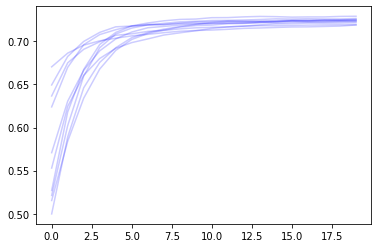

In [38]:
for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['binary_accuracy'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)

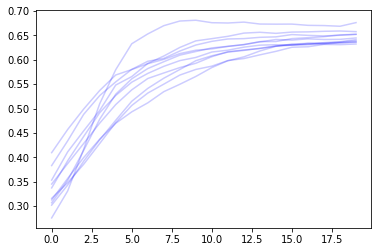

In [39]:
for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['Precision'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)

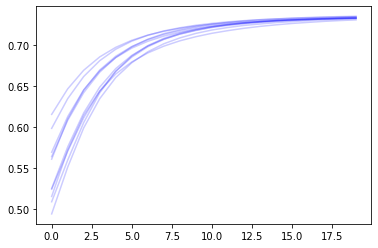

In [40]:
for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['AUC'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)

Text(0.5, 0, 'Round')

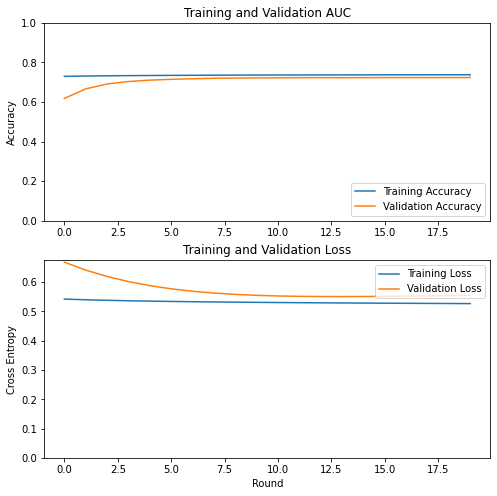

In [64]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results['accuracy'], label='Training Accuracy')
ax1.plot(results['val_accuracy'], label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation AUC')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results['loss'], label='Training Loss')
ax2.plot(results['val_loss'], label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Round')

# plt.savefig('./figures/DELIRIUM_normalized_TFF_accuracy_loss_10_rounds.png')

Text(0.5, 0, 'Round')

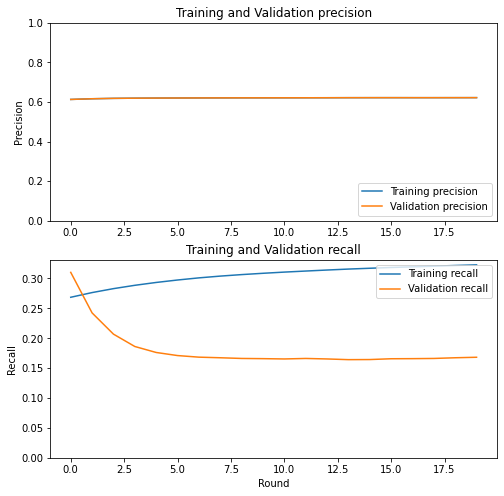

In [65]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(results['precision'], label='Training precision')
ax1.plot(results['val_precision'], label='Validation precision')
ax1.legend(loc='lower right')
ax1.set_ylabel('Precision')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation precision')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(results['recall'], label='Training recall')
ax2.plot(results['val_recall'], label='Validation recall')
ax2.legend(loc='upper right')
ax2.set_ylabel('Recall')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation recall')
ax2.set_xlabel('Round')

# Individual model(s)

In [41]:
%%time
results1 = []

for i in range(10):
    print()
    print(i)
    
    train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
            client_ids=[1], 
            serializable_dataset_fn=create_tf_dataset_for_client_fn)

    federated_train_data1 = make_federated_data(train_data, [1])

    iterative_process1 = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))

    result1 = training_loop(federated_train_data1, federated_test_data, iterative_process1, 20)
    results1.append(result1)


0

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6775      0.275  0.045833  0.491927  0.650198         0.725005   

   Precision    Recall       AUC      loss  
0   0.606722  0.236925  0.715253  0.549068  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6775   0.275000  0.045833  0.491927  0.650198         0.725005   
1           0.6971   0.418994  0.025000  0.546884  0.629255         0.727368   

   Precision    Recall       AUC      loss  
0   0.606722  0.236925  0.715253  0.549068  
1   0.612508  0.248330  0.720353  0.545727  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.67750   0.275000  0.045833  0.491927  0.650198         0.725005   
1          0.69710   0.418994  0.025000  0.546884  0.629255         0.727368   
2          0.70005   0.502347  0.017833  0.596543  0.612413         0.729140   

   Precision    Recall       AUC      loss  
0


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67750   0.275000  0.045833  0.491927  0.650198         0.725005   
1           0.69710   0.418994  0.025000  0.546884  0.629255         0.727368   
2           0.70005   0.502347  0.017833  0.596543  0.612413         0.729140   
3           0.70115   0.563536  0.017000  0.634222  0.598982         0.730542   
4           0.70300   0.653061  0.021333  0.661055  0.588402         0.731839   
5           0.70415   0.673640  0.026833  0.679103  0.580202         0.732898   
6           0.70535   0.687719  0.032667  0.691684  0.573982         0.733831   
7           0.70610   0.687117  0.037333  0.700539  0.569395         0.734782   
8           0.70790   0.705729  0.045167  0.706858  0.566147         0.735560   
9           0.70860   0.699074  0.050333  0.711540  0.563995         0.736223   
10          0.70990   0.703704  0.057000  0.715191  0.562714         0.736884   
11          0.71060   0.700


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.67750   0.275000  0.045833  0.491927  0.650198         0.725005   
1           0.69710   0.418994  0.025000  0.546884  0.629255         0.727368   
2           0.70005   0.502347  0.017833  0.596543  0.612413         0.729140   
3           0.70115   0.563536  0.017000  0.634222  0.598982         0.730542   
4           0.70300   0.653061  0.021333  0.661055  0.588402         0.731839   
5           0.70415   0.673640  0.026833  0.679103  0.580202         0.732898   
6           0.70535   0.687719  0.032667  0.691684  0.573982         0.733831   
7           0.70610   0.687117  0.037333  0.700539  0.569395         0.734782   
8           0.70790   0.705729  0.045167  0.706858  0.566147         0.735560   
9           0.70860   0.699074  0.050333  0.711540  0.563995         0.736223   
10          0.70990   0.703704  0.057000  0.715191  0.562714         0.736884   
11          0.71060   0.700


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.5725   0.339744  0.4505  0.558296  0.678288         0.724132   

   Precision    Recall       AUC      loss  
0   0.599612  0.242103  0.715602  0.548275  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57250   0.339744  0.450500  0.558296  0.678288         0.724132   
1          0.65475   0.408047  0.334667  0.612748  0.647299         0.726717   

   Precision    Recall       AUC      loss  
0   0.599612  0.242103  0.715602  0.548275  
1   0.606755  0.253078  0.720482  0.545100  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57250   0.339744  0.450500  0.558296  0.678288         0.724132   
1          0.65475   0.408047  0.334667  0.612748  0.647299         0.726717   
2          0.69115   0.473637  0.265000  0.650300  0.622333         0.728698   

   Precision    Recall       AUC      loss  
0   0.59


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57250   0.339744  0.450500  0.558296  0.678288         0.724132   
1           0.65475   0.408047  0.334667  0.612748  0.647299         0.726717   
2           0.69115   0.473637  0.265000  0.650300  0.622333         0.728698   
3           0.70535   0.521171  0.219500  0.674632  0.602404         0.730257   
4           0.71295   0.562651  0.193833  0.690287  0.586720         0.731524   
5           0.71635   0.589101  0.180167  0.700858  0.574563         0.732614   
6           0.71790   0.605917  0.170667  0.708242  0.565310         0.733531   
7           0.71795   0.611978  0.163500  0.713471  0.558442         0.734290   
8           0.71955   0.623970  0.164000  0.717375  0.553505         0.734989   
9           0.71975   0.628497  0.161000  0.720138  0.550117         0.735654   
10          0.72060   0.636786  0.159833  0.722386  0.547951         0.736230   
11          0.72100   0.642


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57250   0.339744  0.450500  0.558296  0.678288         0.724132   
1           0.65475   0.408047  0.334667  0.612748  0.647299         0.726717   
2           0.69115   0.473637  0.265000  0.650300  0.622333         0.728698   
3           0.70535   0.521171  0.219500  0.674632  0.602404         0.730257   
4           0.71295   0.562651  0.193833  0.690287  0.586720         0.731524   
5           0.71635   0.589101  0.180167  0.700858  0.574563         0.732614   
6           0.71790   0.605917  0.170667  0.708242  0.565310         0.733531   
7           0.71795   0.611978  0.163500  0.713471  0.558442         0.734290   
8           0.71955   0.623970  0.164000  0.717375  0.553505         0.734989   
9           0.71975   0.628497  0.161000  0.720138  0.550117         0.735654   
10          0.72060   0.636786  0.159833  0.722386  0.547951         0.736230   
11          0.72100   0.642


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5739   0.368372  0.588167  0.602813  0.682504         0.723613   

   Precision    Recall       AUC      loss  
0   0.595784  0.244792  0.713157  0.550613  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57390   0.368372  0.588167  0.602813  0.682504         0.723613   
1          0.63125   0.407656  0.505833  0.630448  0.651436         0.726309   

   Precision    Recall       AUC      loss  
0   0.595784  0.244792  0.713157  0.550613  
1   0.603595  0.255482  0.718244  0.547293  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.57390   0.368372  0.588167  0.602813  0.682504         0.723613   
1          0.63125   0.407656  0.505833  0.630448  0.651436         0.726309   
2          0.66815   0.445750  0.436167  0.652246  0.626505         0.728326   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57390   0.368372  0.588167  0.602813  0.682504         0.723613   
1           0.63125   0.407656  0.505833  0.630448  0.651436         0.726309   
2           0.66815   0.445750  0.436167  0.652246  0.626505         0.728326   
3           0.68985   0.478690  0.380000  0.669019  0.606601         0.729908   
4           0.70350   0.508759  0.338833  0.681933  0.590868         0.731184   
5           0.71085   0.531404  0.306000  0.691909  0.578575         0.732280   
6           0.71525   0.549984  0.279667  0.699668  0.569121         0.733249   
7           0.71755   0.563610  0.259167  0.705813  0.561988         0.734060   
8           0.71935   0.577000  0.241667  0.710446  0.556727         0.734788   
9           0.72145   0.591083  0.232000  0.714289  0.552983         0.735505   
10          0.72205   0.597696  0.224833  0.717249  0.550446         0.736181   
11          0.72230   0.604


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.57390   0.368372  0.588167  0.602813  0.682504         0.723613   
1           0.63125   0.407656  0.505833  0.630448  0.651436         0.726309   
2           0.66815   0.445750  0.436167  0.652246  0.626505         0.728326   
3           0.68985   0.478690  0.380000  0.669019  0.606601         0.729908   
4           0.70350   0.508759  0.338833  0.681933  0.590868         0.731184   
5           0.71085   0.531404  0.306000  0.691909  0.578575         0.732280   
6           0.71525   0.549984  0.279667  0.699668  0.569121         0.733249   
7           0.71755   0.563610  0.259167  0.705813  0.561988         0.734060   
8           0.71935   0.577000  0.241667  0.710446  0.556727         0.734788   
9           0.72145   0.591083  0.232000  0.714289  0.552983         0.735505   
10          0.72205   0.597696  0.224833  0.717249  0.550446         0.736181   
11          0.72230   0.604


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63445   0.387468  0.376167  0.603287  0.670858         0.726516   

   Precision    Recall      AUC     loss  
0   0.602168  0.260472  0.72033  0.54546  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63445   0.387468  0.376167  0.603287  0.670858         0.726516   
1          0.66805   0.426467  0.308833  0.633396  0.642459         0.728544   

   Precision    Recall       AUC      loss  
0   0.602168  0.260472  0.720330  0.545460  
1   0.607427  0.268995  0.724029  0.542916  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63445   0.387468  0.376167  0.603287  0.670858         0.726516   
1          0.66805   0.426467  0.308833  0.633396  0.642459         0.728544   
2          0.68795   0.463976  0.258667  0.655852  0.619819         0.730099   

   Precision    Recall       AUC      loss  
0   0.60


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63445   0.387468  0.376167  0.603287  0.670858         0.726516   
1           0.66805   0.426467  0.308833  0.633396  0.642459         0.728544   
2           0.68795   0.463976  0.258667  0.655852  0.619819         0.730099   
3           0.69705   0.489070  0.220000  0.672071  0.601954         0.731369   
4           0.70195   0.508402  0.196667  0.684063  0.587991         0.732439   
5           0.70610   0.530348  0.177667  0.693135  0.577221         0.733302   
6           0.70865   0.547816  0.165167  0.699954  0.569058         0.734105   
7           0.71075   0.565112  0.155500  0.705147  0.563006         0.734908   
8           0.71240   0.580415  0.149167  0.709326  0.558654         0.735650   
9           0.71420   0.597527  0.145000  0.712716  0.555651         0.736297   
10          0.71535   0.610671  0.141167  0.715424  0.553710         0.736926   
11          0.71670   0.625


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63445   0.387468  0.376167  0.603287  0.670858         0.726516   
1           0.66805   0.426467  0.308833  0.633396  0.642459         0.728544   
2           0.68795   0.463976  0.258667  0.655852  0.619819         0.730099   
3           0.69705   0.489070  0.220000  0.672071  0.601954         0.731369   
4           0.70195   0.508402  0.196667  0.684063  0.587991         0.732439   
5           0.70610   0.530348  0.177667  0.693135  0.577221         0.733302   
6           0.70865   0.547816  0.165167  0.699954  0.569058         0.734105   
7           0.71075   0.565112  0.155500  0.705147  0.563006         0.734908   
8           0.71240   0.580415  0.149167  0.709326  0.558654         0.735650   
9           0.71420   0.597527  0.145000  0.712716  0.555651         0.736297   
10          0.71535   0.610671  0.141167  0.715424  0.553710         0.736926   
11          0.71670   0.625


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56745   0.350074  0.515833  0.571751  0.686371         0.724311   

   Precision    Recall       AUC      loss  
0   0.598202  0.246825  0.715692  0.549514  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56745   0.350074  0.515833  0.571751  0.686371         0.724311   
1          0.64170   0.406809  0.424167  0.621539  0.655623         0.726601   

   Precision    Recall       AUC      loss  
0   0.598202  0.246825  0.715692  0.549514  
1   0.604248  0.256972  0.720664  0.546142  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.56745   0.350074  0.515833  0.571751  0.686371         0.724311   
1          0.64170   0.406809  0.424167  0.621539  0.655623         0.726601   
2          0.68350   0.464115  0.355667  0.656458  0.630304         0.728360   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56745   0.350074  0.515833  0.571751  0.686371         0.724311   
1           0.64170   0.406809  0.424167  0.621539  0.655623         0.726601   
2           0.68350   0.464115  0.355667  0.656458  0.630304         0.728360   
3           0.70450   0.512465  0.308333  0.679181  0.609755         0.729647   
4           0.71340   0.543366  0.279833  0.693920  0.593227         0.730717   
5           0.71935   0.570440  0.261167  0.703565  0.580076         0.731591   
6           0.72195   0.587346  0.246000  0.710365  0.569763         0.732409   
7           0.72355   0.599661  0.236167  0.714989  0.561788         0.733070   
8           0.72485   0.610004  0.229667  0.718493  0.555739         0.733639   
9           0.72510   0.614403  0.224667  0.721088  0.551266         0.734258   
10          0.72615   0.621798  0.222500  0.723106  0.548065         0.734825   
11          0.72715   0.629


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.56745   0.350074  0.515833  0.571751  0.686371         0.724311   
1           0.64170   0.406809  0.424167  0.621539  0.655623         0.726601   
2           0.68350   0.464115  0.355667  0.656458  0.630304         0.728360   
3           0.70450   0.512465  0.308333  0.679181  0.609755         0.729647   
4           0.71340   0.543366  0.279833  0.693920  0.593227         0.730717   
5           0.71935   0.570440  0.261167  0.703565  0.580076         0.731591   
6           0.72195   0.587346  0.246000  0.710365  0.569763         0.732409   
7           0.72355   0.599661  0.236167  0.714989  0.561788         0.733070   
8           0.72485   0.610004  0.229667  0.718493  0.555739         0.733639   
9           0.72510   0.614403  0.224667  0.721088  0.551266         0.734258   
10          0.72615   0.621798  0.222500  0.723106  0.548065         0.734825   
11          0.72715   0.629


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.63445    0.36437  0.2935  0.575588  0.667229         0.724981   

   Precision    Recall       AUC      loss  
0   0.605193  0.239538  0.715708  0.548098  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.63445   0.364370  0.2935  0.575588  0.667229         0.724981   
1          0.66695   0.405056  0.2350  0.612017  0.637906         0.727439   

   Precision    Recall       AUC      loss  
0   0.605193  0.239538  0.715708  0.548098  
1   0.611304  0.251168  0.720501  0.545003  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.63445   0.364370  0.293500  0.575588  0.667229         0.724981   
1          0.66695   0.405056  0.235000  0.612017  0.637906         0.727439   
2          0.68460   0.442192  0.196333  0.639889  0.614793         0.729323   

   Precision    Recall       AUC      loss  
0   0.605193  


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63445   0.364370  0.293500  0.575588  0.667229         0.724981   
1           0.66695   0.405056  0.235000  0.612017  0.637906         0.727439   
2           0.68460   0.442192  0.196333  0.639889  0.614793         0.729323   
3           0.69500   0.477498  0.176833  0.661090  0.596807         0.730818   
4           0.70170   0.509189  0.157000  0.676847  0.583059         0.731906   
5           0.70585   0.535051  0.148833  0.688754  0.572779         0.732804   
6           0.70840   0.554902  0.141500  0.697935  0.565291         0.733567   
7           0.71060   0.573816  0.137333  0.704840  0.560082         0.734111   
8           0.71305   0.596452  0.134500  0.710152  0.556699         0.734606   
9           0.71445   0.611583  0.132000  0.714519  0.554743         0.735013   
10          0.71495   0.615981  0.132333  0.717764  0.553892         0.735359   
11          0.71580   0.625


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.63445   0.364370  0.293500  0.575588  0.667229         0.724981   
1           0.66695   0.405056  0.235000  0.612017  0.637906         0.727439   
2           0.68460   0.442192  0.196333  0.639889  0.614793         0.729323   
3           0.69500   0.477498  0.176833  0.661090  0.596807         0.730818   
4           0.70170   0.509189  0.157000  0.676847  0.583059         0.731906   
5           0.70585   0.535051  0.148833  0.688754  0.572779         0.732804   
6           0.70840   0.554902  0.141500  0.697935  0.565291         0.733567   
7           0.71060   0.573816  0.137333  0.704840  0.560082         0.734111   
8           0.71305   0.596452  0.134500  0.710152  0.556699         0.734606   
9           0.71445   0.611583  0.132000  0.714519  0.554743         0.735013   
10          0.71495   0.615981  0.132333  0.717764  0.553892         0.735359   
11          0.71580   0.625


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.50415   0.339507  0.6905  0.582077  0.721786         0.724293   

   Precision    Recall       AUC      loss  
0   0.598654  0.245687  0.713979  0.549189  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.50415   0.339507  0.690500  0.582077  0.721786         0.724293   
1          0.60720   0.393333  0.570333  0.622477  0.681569         0.726554   

   Precision    Recall       AUC      loss  
0   0.598654  0.245687  0.713979  0.549189  
1   0.604613  0.255782  0.718555  0.546143  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.50415   0.339507  0.690500  0.582077  0.721786         0.724293   
1          0.60720   0.393333  0.570333  0.622477  0.681569         0.726554   
2          0.66010   0.437812  0.468167  0.651474  0.649596         0.728269   

   Precision    Recall       AUC      loss  
0   0.59


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.50415   0.339507  0.690500  0.582077  0.721786         0.724293   
1           0.60720   0.393333  0.570333  0.622477  0.681569         0.726554   
2           0.66010   0.437812  0.468167  0.651474  0.649596         0.728269   
3           0.68865   0.477168  0.395333  0.671867  0.624259         0.729622   
4           0.70425   0.510570  0.342167  0.686038  0.604274         0.730627   
5           0.71240   0.536686  0.302333  0.696249  0.588645         0.731416   
6           0.71685   0.556983  0.274500  0.703659  0.576510         0.731969   
7           0.72050   0.577710  0.254000  0.709296  0.567212         0.732581   
8           0.72190   0.589828  0.239667  0.713630  0.560174         0.733203   
9           0.72215   0.599017  0.223333  0.716937  0.554948         0.733751   
10          0.72280   0.607852  0.214167  0.719485  0.551169         0.734326   
11          0.72340   0.618


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.50415   0.339507  0.690500  0.582077  0.721786         0.724293   
1           0.60720   0.393333  0.570333  0.622477  0.681569         0.726554   
2           0.66010   0.437812  0.468167  0.651474  0.649596         0.728269   
3           0.68865   0.477168  0.395333  0.671867  0.624259         0.729622   
4           0.70425   0.510570  0.342167  0.686038  0.604274         0.730627   
5           0.71240   0.536686  0.302333  0.696249  0.588645         0.731416   
6           0.71685   0.556983  0.274500  0.703659  0.576510         0.731969   
7           0.72050   0.577710  0.254000  0.709296  0.567212         0.732581   
8           0.72190   0.589828  0.239667  0.713630  0.560174         0.733203   
9           0.72215   0.599017  0.223333  0.716937  0.554948         0.733751   
10          0.72280   0.607852  0.214167  0.719485  0.551169         0.734326   
11          0.72340   0.618


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49975   0.318795  0.587167  0.531242  0.720319          0.72355   

   Precision    Recall       AUC      loss  
0   0.594016  0.247997  0.717692  0.547166  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49975   0.318795  0.587167  0.531242  0.720319         0.723550   
1          0.59345   0.364492  0.477667  0.587138  0.677963         0.725946   

   Precision    Recall       AUC      loss  
0   0.594016  0.247997  0.717692  0.547166  
1   0.600810  0.257723  0.722189  0.544172  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.49975   0.318795  0.587167  0.531242  0.720319         0.723550   
1          0.59345   0.364492  0.477667  0.587138  0.677963         0.725946   
2          0.65660   0.421886  0.390667  0.632645  0.644511         0.727785   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.49975   0.318795  0.587167  0.531242  0.720319         0.723550   
1           0.59345   0.364492  0.477667  0.587138  0.677963         0.725946   
2           0.65660   0.421886  0.390667  0.632645  0.644511         0.727785   
3           0.68855   0.472323  0.325667  0.664356  0.618267         0.729288   
4           0.70395   0.511851  0.284333  0.685242  0.597865         0.730579   
5           0.71305   0.547163  0.252333  0.699015  0.582198         0.731600   
6           0.71650   0.567623  0.230833  0.708175  0.570373         0.732406   
7           0.71915   0.587323  0.214667  0.714388  0.561592         0.733147   
8           0.72040   0.598361  0.206833  0.718743  0.555273         0.733782   
9           0.72205   0.612328  0.200333  0.721779  0.550893         0.734303   
10          0.72170   0.616167  0.191833  0.723972  0.548049         0.734761   
11          0.72150   0.618


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.49975   0.318795  0.587167  0.531242  0.720319         0.723550   
1           0.59345   0.364492  0.477667  0.587138  0.677963         0.725946   
2           0.65660   0.421886  0.390667  0.632645  0.644511         0.727785   
3           0.68855   0.472323  0.325667  0.664356  0.618267         0.729288   
4           0.70395   0.511851  0.284333  0.685242  0.597865         0.730579   
5           0.71305   0.547163  0.252333  0.699015  0.582198         0.731600   
6           0.71650   0.567623  0.230833  0.708175  0.570373         0.732406   
7           0.71915   0.587323  0.214667  0.714388  0.561592         0.733147   
8           0.72040   0.598361  0.206833  0.718743  0.555273         0.733782   
9           0.72205   0.612328  0.200333  0.721779  0.550893         0.734303   
10          0.72170   0.616167  0.191833  0.723972  0.548049         0.734761   
11          0.72150   0.618


   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0          0.69355   0.413655  0.0515  0.595718  0.614458          0.72531   

   Precision    Recall       AUC      loss  
0   0.610399  0.233233  0.717126  0.547602  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.69355   0.413655  0.051500  0.595718  0.614458          0.72531   
1          0.69845   0.469062  0.039167  0.634899  0.598764          0.72759   

   Precision    Recall       AUC      loss  
0   0.610399  0.233233  0.717126  0.547602  
1   0.615074  0.245782  0.721828  0.544577  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.69355   0.413655  0.051500  0.595718  0.614458         0.725310   
1          0.69845   0.469062  0.039167  0.634899  0.598764         0.727590   
2          0.70005   0.501355  0.030833  0.662660  0.586737         0.729417   

   Precision    Recall       AUC      loss  
0   0.61


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.69355   0.413655  0.051500  0.595718  0.614458         0.725310   
1           0.69845   0.469062  0.039167  0.634899  0.598764         0.727590   
2           0.70005   0.501355  0.030833  0.662660  0.586737         0.729417   
3           0.70165   0.551724  0.029333  0.681811  0.577792         0.730883   
4           0.70275   0.593857  0.029000  0.695052  0.571421         0.732047   
5           0.70340   0.616438  0.030000  0.704244  0.567180         0.733024   
6           0.70405   0.636364  0.031500  0.711034  0.564683         0.733840   
7           0.70475   0.657807  0.033000  0.715689  0.563581         0.734478   
8           0.70540   0.676471  0.034500  0.719270  0.563595         0.735084   
9           0.70625   0.694704  0.037167  0.721847  0.564474         0.735536   
10          0.70650   0.698171  0.038167  0.723843  0.566005         0.735975   
11          0.70700   0.707


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.69355   0.413655  0.051500  0.595718  0.614458         0.725310   
1           0.69845   0.469062  0.039167  0.634899  0.598764         0.727590   
2           0.70005   0.501355  0.030833  0.662660  0.586737         0.729417   
3           0.70165   0.551724  0.029333  0.681811  0.577792         0.730883   
4           0.70275   0.593857  0.029000  0.695052  0.571421         0.732047   
5           0.70340   0.616438  0.030000  0.704244  0.567180         0.733024   
6           0.70405   0.636364  0.031500  0.711034  0.564683         0.733840   
7           0.70475   0.657807  0.033000  0.715689  0.563581         0.734478   
8           0.70540   0.676471  0.034500  0.719270  0.563595         0.735084   
9           0.70625   0.694704  0.037167  0.721847  0.564474         0.735536   
10          0.70650   0.698171  0.038167  0.723843  0.566005         0.735975   
11          0.70700   0.707


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.65885    0.29332  0.097333  0.521361  0.644186         0.725605   

   Precision    Recall       AUC      loss  
0   0.605888  0.244185  0.715785  0.548544  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.65885   0.293320  0.097333  0.521361  0.644186         0.725605   
1          0.68555   0.374019  0.071500  0.573722  0.622044         0.727896   

   Precision    Recall       AUC      loss  
0   0.605888  0.244185  0.715785  0.548544  
1   0.611437  0.255102  0.720613  0.545474  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0          0.65885   0.293320  0.097333  0.521361  0.644186         0.725605   
1          0.68555   0.374019  0.071500  0.573722  0.622044         0.727896   
2          0.69650   0.453457  0.056833  0.617376  0.604584         0.729478   

   Precision    Recall       AUC      loss  
0   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.65885   0.293320  0.097333  0.521361  0.644186         0.725605   
1           0.68555   0.374019  0.071500  0.573722  0.622044         0.727896   
2           0.69650   0.453457  0.056833  0.617376  0.604584         0.729478   
3           0.70075   0.512479  0.051333  0.649886  0.591032         0.730799   
4           0.70450   0.583643  0.052333  0.672464  0.580722         0.731920   
5           0.70585   0.611006  0.053667  0.687941  0.573099         0.732813   
6           0.70780   0.644444  0.058000  0.698793  0.567676         0.733626   
7           0.70960   0.669611  0.063167  0.706338  0.564042         0.734303   
8           0.71020   0.671141  0.066667  0.711915  0.561828         0.734971   
9           0.71210   0.692675  0.072500  0.715993  0.560744         0.735551   
10          0.71345   0.704718  0.077167  0.719051  0.560546         0.736056   
11          0.71420   0.706


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.65885   0.293320  0.097333  0.521361  0.644186         0.725605   
1           0.68555   0.374019  0.071500  0.573722  0.622044         0.727896   
2           0.69650   0.453457  0.056833  0.617376  0.604584         0.729478   
3           0.70075   0.512479  0.051333  0.649886  0.591032         0.730799   
4           0.70450   0.583643  0.052333  0.672464  0.580722         0.731920   
5           0.70585   0.611006  0.053667  0.687941  0.573099         0.732813   
6           0.70780   0.644444  0.058000  0.698793  0.567676         0.733626   
7           0.70960   0.669611  0.063167  0.706338  0.564042         0.734303   
8           0.71020   0.671141  0.066667  0.711915  0.561828         0.734971   
9           0.71210   0.692675  0.072500  0.715993  0.560744         0.735551   
10          0.71345   0.704718  0.077167  0.719051  0.560546         0.736056   
11          0.71420   0.706

In [42]:
pickle.dump(results1, open("results1.pkl.gz",'wb'))
#results = pickle.load(open("results.pkl.gz",'rb'))

# Some plots

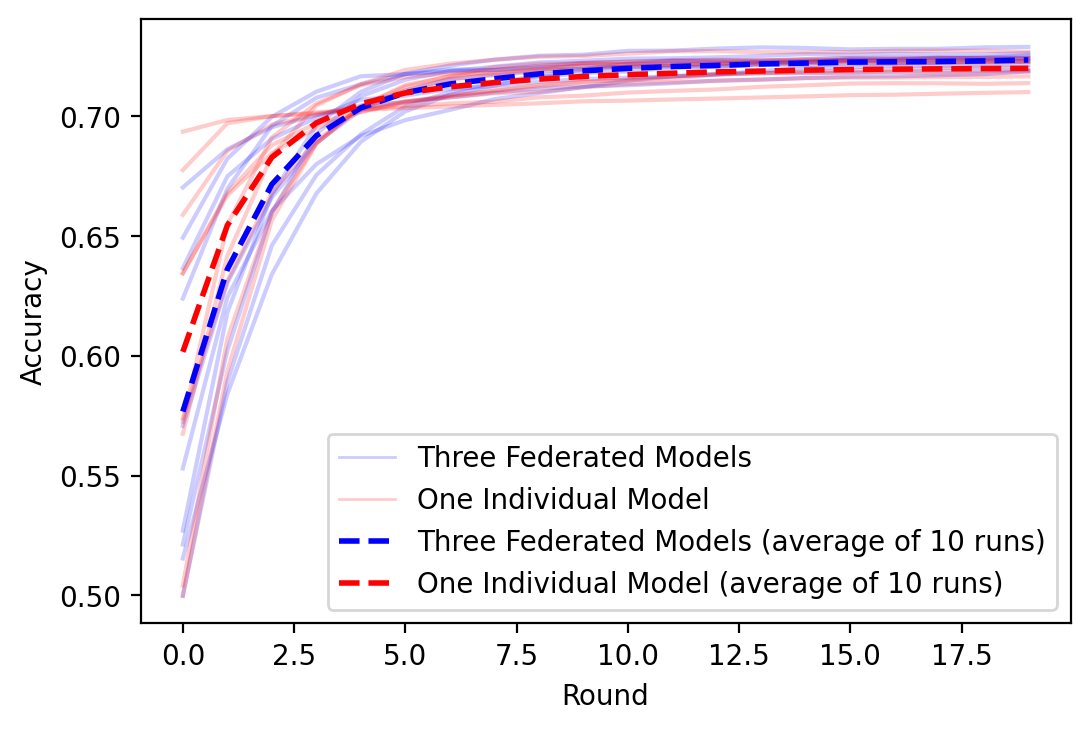

In [68]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['binary_accuracy'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results1[j]['eval'][i]['eval']['binary_accuracy'] for i in range(len(results1[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results[j]['eval'][i]['eval']['binary_accuracy'] for j in range(10)]) for i in range(len(results[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results1[j]['eval'][i]['eval']['binary_accuracy'] for j in range(10)]) for i in range(len(results1[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Accuracy")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Three Federated Models', 'One Individual Model', 'Three Federated Models (average of 10 runs)', 'One Individual Model (average of 10 runs)',]
)

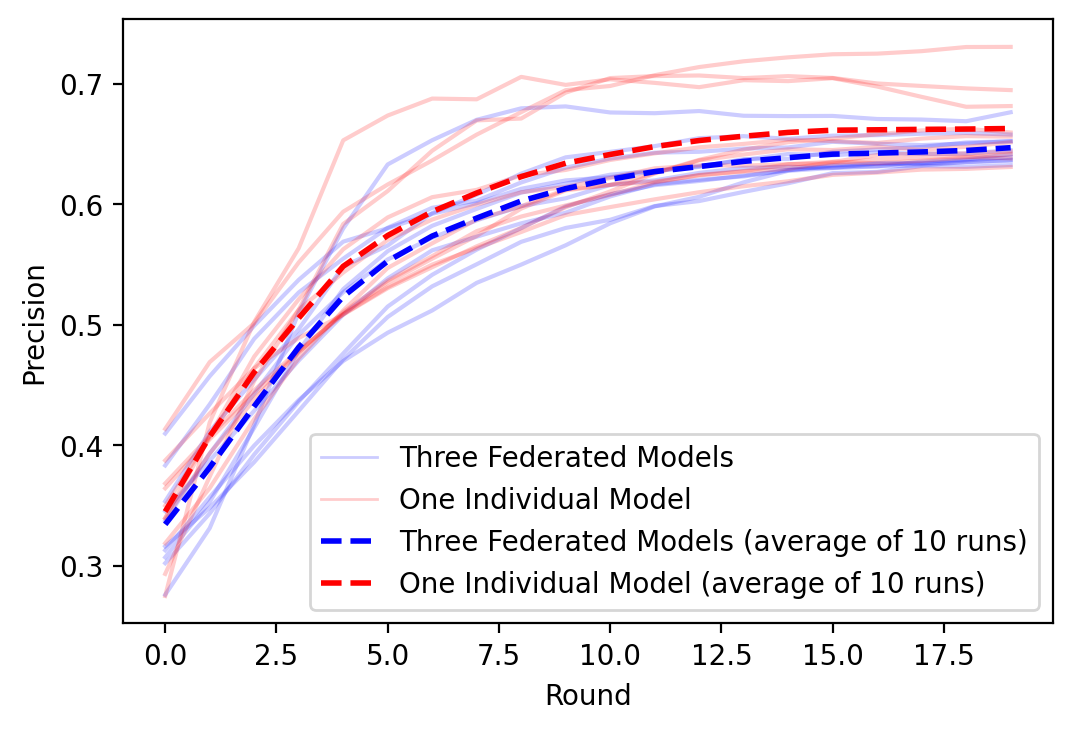

In [69]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['Precision'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results1[j]['eval'][i]['eval']['Precision'] for i in range(len(results1[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results[j]['eval'][i]['eval']['Precision'] for j in range(10)]) for i in range(len(results[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results1[j]['eval'][i]['eval']['Precision'] for j in range(10)]) for i in range(len(results1[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Precision")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Three Federated Models', 'One Individual Model', 'Three Federated Models (average of 10 runs)', 'One Individual Model (average of 10 runs)',]
)

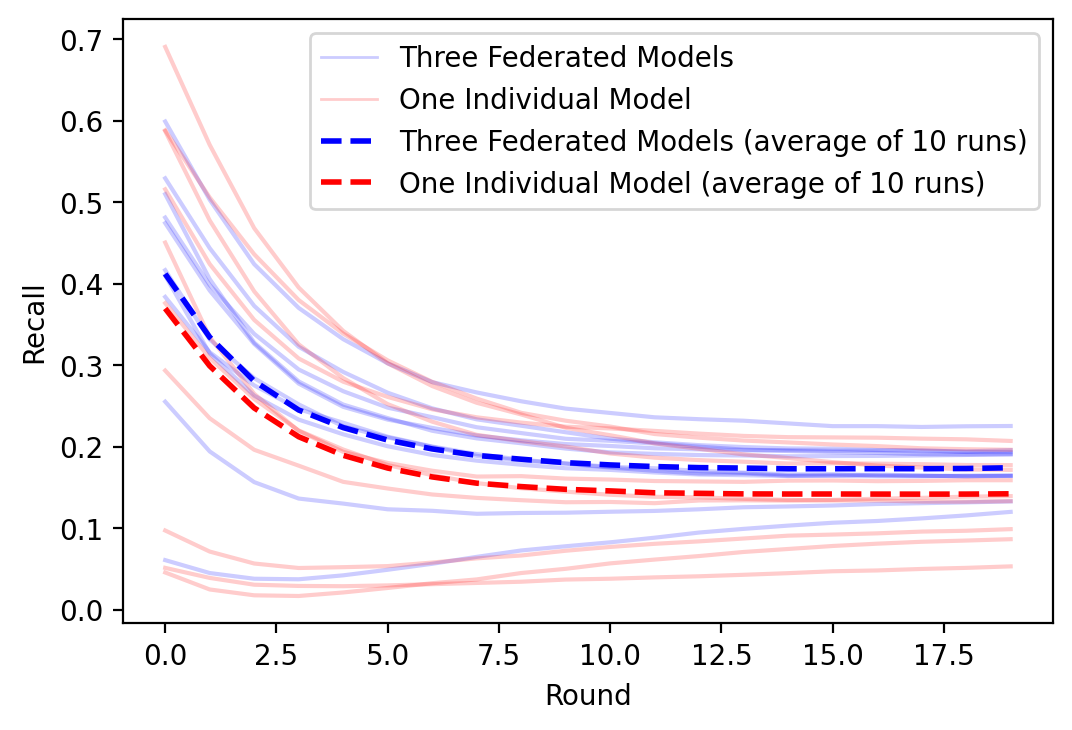

In [70]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['Recall'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results1[j]['eval'][i]['eval']['Recall'] for i in range(len(results1[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results[j]['eval'][i]['eval']['Recall'] for j in range(10)]) for i in range(len(results[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results1[j]['eval'][i]['eval']['Recall'] for j in range(10)]) for i in range(len(results1[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("Recall")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Three Federated Models', 'One Individual Model', 'Three Federated Models (average of 10 runs)', 'One Individual Model (average of 10 runs)',]
)

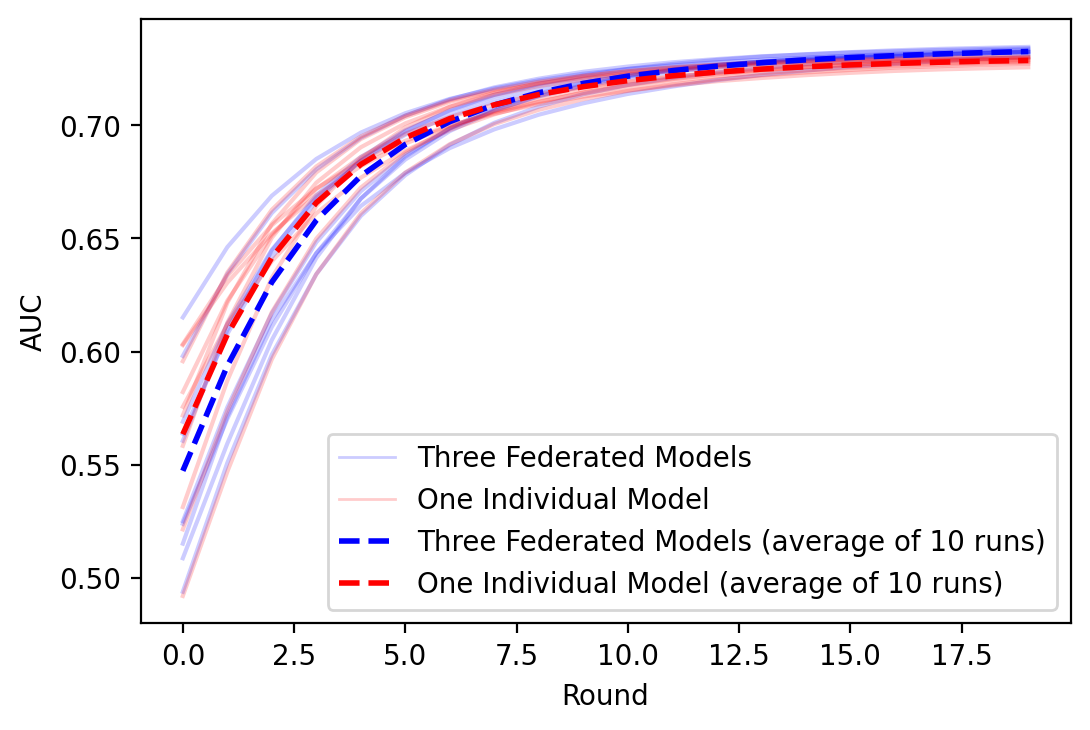

In [71]:
plt.subplots(dpi=200)

for j in range(10):
    plt.plot([results[j]['eval'][i]['eval']['AUC'] for i in range(len(results[j]['eval']))], c='b', alpha=0.2)
    
for j in range(10):
    plt.plot([results1[j]['eval'][i]['eval']['AUC'] for i in range(len(results1[j]['eval']))], c='r', alpha=0.2)

plt.plot(
    [np.mean([results[j]['eval'][i]['eval']['AUC'] for j in range(10)]) for i in range(len(results[0]['eval']))],
    lw=2,
    c='b',
    ls='--'
)
plt.plot(
    [np.mean([results1[j]['eval'][i]['eval']['AUC'] for j in range(10)]) for i in range(len(results1[0]['eval']))],
    lw=2,
    c='r',
    ls='--'
)
    
plt.xlabel("Round")
plt.ylabel("AUC")

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], lw=1, c='b', alpha=0.2),
    Line2D([0], [0], lw=1, c='r', alpha=0.2),
    Line2D([0], [0], lw=2, c='b', ls='--'),
    Line2D([0], [0], lw=2, c='r', ls='--'),
               ]

#lines = ax.plot(data)
plt.legend(
    custom_lines, 
    ['Three Federated Models', 'One Individual Model', 'Three Federated Models (average of 10 runs)', 'One Individual Model (average of 10 runs)',]
)